In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Ipynb_importer
from utils_x import *
from parameters_x import *

print("------------------- load data--------------------")
data = pd.read_csv('index300_v3.csv')
print(data)
del data["Unnamed: 0"]
time_series = list(sorted(set(list(data.date_time))))    
n_use_f = set(np.array(['unique_symbol', 'date_time', 't+1_open','t+2_open', 'return', 'label', 'rank_label', "use_tag"]))
use_f = list(set(np.array(data.columns)) - n_use_f)
print(sorted(use_f))
print(len(use_f))


importing Jupyter notebook from utils_x.ipynb
importing Jupyter notebook from parameters_x.ipynb
------------------- load data--------------------
        Unnamed: 0  unique_symbol   date_time  close     turnover   open  \
0                1            402  2010-01-04  11.71  725948276.0  12.16   
1                2            401  2010-01-04  19.15  229544752.0  19.35   
2                4            338  2010-01-04  63.62  228205696.0  64.99   
3                5            301  2010-01-04   7.05  100006080.0   7.03   
4                6            157  2010-01-04  25.57  254864320.0  26.16   
...            ...            ...         ...    ...          ...    ...   
556680      989119         600737  2017-12-27   8.02   54718108.0   8.07   
556681      989120         600739  2017-12-27  17.24   72086344.0  17.41   
556682      989123         600741  2017-12-27  28.43  336718555.0  28.38   
556683      989127         600795  2017-12-27   3.08  155046382.0   3.06   
556684      98912

In [2]:
data = data.dropna(how='any',axis=0) 

In [11]:
all_re = []
all_buy_v = []
all_sell_v = []
all_pre = []
all_real_label = []
all_market_return = []
all_te_time = []
all_turn = []


data = data[~data['return'].isnull()].copy()
print(len(data))
      
print("-------------------- train -----------------------")
for i in range(1):
    year = 2010+i
    print(year)
    tr_time = select_year(str(year), time_series) + select_year(str(year+1), time_series) + \
              select_year(str(year+2), time_series) + select_year(str(year+3), time_series)
    te_time = select_year(str(year+4), time_series) + select_year(str(year+5), time_series) + select_year(str(year+6), time_series)
    print(len(tr_time))
    print(len(te_time))
    print(len(list(set(tr_time)-set(te_time))))
    data_tr = data[data["date_time"].isin(tr_time)].copy()
    data_te = data[data["date_time"].isin(te_time)].copy()

    print(len(set(data_tr["date_time"])))
    print(len(set(data_te["date_time"])))
    X_train = data_tr[use_f]
    y_train = data_tr['label']
    X_test = data_te[use_f]
    y_test = data_te['label']

#     market_return = list(data[data["date_time"].isin(list(data_te.time))].groupby(['time'])['return'].mean())
    bst = train_op(X_train, y_train, params, num_rounds, X_test, y_test, early)  # 进行训练
    importance_dic = f_importance(bst, use_f)
    re, pre, real_label, turn = simple_re_wheeled(data_te, use_f, bst, version='long')
    all_re = all_re + re
    all_pre = all_pre + pre
    all_real_label = all_real_label + real_label
#     all_market_return = all_market_return + market_return
    all_te_time = all_te_time + list(sorted(set(list(data_te['date_time']))))
    all_turn = all_turn + turn
    print(len(all_turn))
    print(len(all_te_time))
# pnl_analysis(all_market_return, all_re, importance_dic, all_buy_v, all_sell_v, all_pre, all_real_label, type='acc')
turnover = turnover_analysis(all_te_time, all_buy_v, all_sell_v, all_turn)
pnl_analysis(all_te_time, all_market_return, all_re, importance_dic, all_pre, all_real_label,  turnover, type='add')

547890
-------------------- train -----------------------
2010
967
733
967
938
733
Empty DataFrame
Columns: [unique_symbol, date_time, close, turnover, open, high, low, volume, use_tag, wap, t+1_open, t+2_open, return, label, rank_label, close1, close2, close3, close4, close5, close6, close7, close8, close9, close10, close11, close12, close13, close14, close15, close16, close17, close18, close19, close20, close21, close22, close23, close24, close25, close26, close27, close28, close29, turnover1, turnover2, turnover3, turnover4, turnover5, turnover6, turnover7, turnover8, turnover9, turnover10, turnover11, turnover12, turnover13, turnover14, turnover15, turnover16, turnover17, turnover18, turnover19, turnover20, turnover21, turnover22, turnover23, turnover24, turnover25, turnover26, turnover27, turnover28, turnover29, open1, open2, open3, open4, open5, open6, open7, open8, open9, open10, open11, open12, open13, open14, open15, open16, open17, open18, open19, open20, open21, open22, open

AttributeError: 'DataFrame' object has no attribute 'time'

In [12]:
simple_re_wheeled(data_te, use_f, bst, version='long')

AttributeError: 'DataFrame' object has no attribute 'time'

In [20]:
f_to_use = use_f
data = data_te
re_list = []
buy_v = []
sell_v = []
rank_pre = []
rank_label = []
turn = []
last_stock_name = []
version = 'long'
time_series = list(sorted(set(list(data['date_time']))))
for day in time_series:
        d_te = data[data['date_time'] == day].copy()[f_to_use]
        all_te = data[data['date_time'] == day].copy()
        X_test = xgb.DMatrix(d_te)
        # print(bst.best_ntree_limit)
        preds = bst.predict(X_test, ntree_limit=bst.best_ntree_limit)
        stock_name = np.array(all_te['unique_symbol'])
        if version == 'long':
            test_bs, test_select_tag = make_decision_long(preds, rightbound)
        test_select_buffer_tag = make_decision_buffer(preds, stock_name, last_stock_name, rightbound, bufferbound)
        test_select_tag = test_select_buffer_tag
        return_list = np.array(all_te['return'])
        stock_list = list(np.array(all_te['unique_symbol'])[test_select_tag])
        # re = (return_list[test_select_tag] * test_bs)
        re = return_list[test_select_tag]
        re_list.append(re.mean())
        print("###############################################")
        print(stock_list)
        print(re.mean(), day)
        print(re)
        rank_pre = rank_pre + list(pd.qcut(pd.Series(preds).rank(method='first'), 10, labels=False))
        rank_label = rank_label + list(all_te['rank_label'])
        turn.append(stock_list)
        last_stock_name = stock_list
        # print(len(stock_list))   

###############################################
[600010, 2241, 2007, 2236, 600783, 2385, 600271, 39, 600118, 2653, 2106, 600600, 2294, 601933, 600372, 600703, 600588, 2038, 793, 895, 600015, 601118, 600718, 963, 600809, 600309, 600123, 600143, 568, 600875]
0.0031460790561666065 2014-01-02
[ 0.0268714   0.02874187 -0.00168919  0.00705882 -0.00050176  0.0064744
  0.00434573 -0.01151631 -0.03504043  0.06855792  0.03005008  0.00063025
 -0.00367959  0.         -0.0124197   0.03558052  0.02836364  0.0037037
  0.01923077 -0.00824474 -0.01818182 -0.04807692  0.01944895  0.02506163
 -0.00578643 -0.0159204  -0.01814709  0.00891266 -0.0111055  -0.02834008]
###############################################
[2241, 39, 568, 600010, 600588, 600015, 600600, 2236, 601118, 895, 601933, 600718, 600372, 600309, 2294, 2038, 2106, 600123, 600703, 600383, 600598, 600376, 601231, 2129, 600196, 603000, 831, 600079, 600066, 2415]
-0.033851490457990595 2014-01-03
[-0.03400105 -0.02265372 -0.03522205 -0.08785047 -0

###############################################
[963, 601992, 601928, 601098, 2603, 596, 2038, 600827, 600637, 600256, 839, 895, 600887, 600703, 600267, 600718, 600804, 600535, 600403, 601238, 601717, 729, 937, 600663, 61, 333, 538, 9, 600970, 601101]
0.0002844951959928473 2014-01-22
[-0.0125      0.01854975  0.027       0.00177305  0.01548349  0.00207039
 -0.00418334 -0.00911162  0.04727723 -0.0223152  -0.00801282 -0.010682
 -0.00793042  0.          0.0078637  -0.00489853  0.02434211  0.01059603
 -0.01195815  0.00921053  0.01903114 -0.03547963 -0.01767305 -0.01885681
 -0.00246914  0.01361827 -0.01246962  0.01237345 -0.01439791 -0.00771605]
###############################################
[2603, 600403, 596, 2038, 600887, 600827, 963, 839, 601928, 600267, 601101, 600718, 793, 24, 600739, 600649, 800, 600783, 2129, 600406, 600648, 600660, 600832, 2594, 600340, 600266, 600352, 600332, 600048, 600549]
0.013332376353222545 2014-01-23
[ 0.05552359  0.00302572 -0.00826446  0.02100457 -0.01057

###############################################
[961, 2146, 2051, 709, 2603, 600875, 793, 600352, 2653, 601231, 600016, 2415, 600150, 603000, 600316, 600637, 2456, 600859, 600256, 568, 718, 601333, 2422, 536, 2304, 600705, 601238, 600703, 703, 600873]
0.0089434248925595 2014-02-18
[ 0.05131414  0.01033058 -0.00384986  0.00543478 -0.02332771 -0.00322581
  0.00347222  0.01956522 -0.00696864 -0.00799361  0.03751617  0.03370787
 -0.02042553 -0.02028986 -0.01995906 -0.0347032  -0.01602434  0.00047393
  0.07731305  0.01432665  0.05349794  0.01090909  0.01083108  0.01430908
  0.04229665 -0.00397501 -0.00817757 -0.03246753  0.08965517 -0.00526316]
###############################################
[2456, 601231, 600256, 600705, 709, 2603, 600150, 601238, 703, 2375, 600196, 601139, 400, 826, 2353, 600436, 600535, 656, 2230, 2450, 600648, 600597, 600332, 600276, 600372, 2129, 600309, 601992, 601158, 600115]
-0.011706192502488343 2014-02-19
[-0.01422387  0.00725222 -0.01764706 -0.00513113 -0.0054054

###############################################
[960, 961, 2, 2241, 2146, 600332, 600271, 400, 2065, 656, 600690, 600597, 2038, 600893, 601633, 601099, 600718, 600535, 600600, 2299, 600637, 600827, 600887, 600340, 538, 2202, 2353, 2304, 600196, 839]
0.014903798440553721 2014-03-10
[ 0.03156917  0.01492537  0.0403338   0.03720178  0.05005441  0.00922013
 -0.00233645  0.00204201  0.0021164   0.02987013 -0.01610018  0.02731655
  0.0207824  -0.01687187  0.03204524  0.01608579  0.01021898  0.02173913
  0.022694   -0.01420118  0.03189138  0.02021403  0.          0.05411877
  0.01456146 -0.01235839  0.00236407  0.00965406  0.01388889 -0.00592593]
###############################################
[960, 961, 2241, 600271, 400, 656, 2038, 600887, 600893, 2304, 600196, 839, 600718, 2065, 2353, 538, 600690, 600597, 600600, 2202, 2594, 2375, 600688, 2129, 601992, 600875, 401, 596, 568, 581]
0.0074203278783752475 2014-03-11
[ 0.00810081  0.03970588  0.06276803  0.00983607  0.00407569  0.0592686
 -0.00

###############################################
[2304, 600519, 2024, 937, 600372, 600376, 600068, 600997, 2375, 600648, 600170, 600403, 2456, 2236, 600340, 709, 600079, 601377, 961, 600516, 600549, 401, 600663, 601139, 600895, 46, 600598, 651, 600688, 601633]
-0.007166879875701518 2014-03-28
[ 0.01136364  0.01776199 -0.00142653 -0.00473186  0.01135135 -0.03564356
 -0.02770781 -0.01511879 -0.00081833 -0.03019538 -0.02843602 -0.03645833
 -0.00660377  0.00600707  0.04866088 -0.00515464 -0.01855817 -0.01028571
 -0.01297017  0.00952381 -0.00128866 -0.00112233 -0.04572098 -0.02567568
 -0.03394625  0.08576642 -0.05021521 -0.00357143  0.         -0.00979192]
###############################################
[600376, 600516, 600519, 600648, 2024, 46, 600079, 401, 600598, 600663, 2456, 709, 600997, 2375, 937, 600170, 600688, 600340, 2236, 600895, 600827, 600018, 601992, 2415, 656, 2065, 2106, 536, 600150, 895]
0.011331000312862194 2014-03-31
[ 0.01232033  0.00673854  0.05190356  0.02564103  0.0242

###############################################
[2241, 2146, 601992, 46, 2353, 600252, 600340, 600597, 24, 156, 600832, 2375, 600648, 2065, 2001, 600372, 600887, 600376, 2106, 895, 600585, 2422, 826, 600316, 601628, 2594, 758, 600528, 601336]
-0.009286467593896022 2014-04-18
[ 0.02241379 -0.03625111  0.00316456 -0.02        0.03018041 -0.00302572
 -0.03846154 -0.02352298 -0.0269341  -0.0075      0.01339286 -0.00479616
  0.04487838  0.01687345 -0.03649635 -0.02639442 -0.0142015  -0.00632911
 -0.02251082  0.00692308 -0.02662037 -0.00544959 -0.001404   -0.03795181
 -0.0078125  -0.00808081 -0.01803607 -0.02040816 -0.01494696]
###############################################
[600832, 600376, 2146, 600585, 2065, 2001, 600340, 600372, 2422, 600887, 24, 156, 2594, 600648, 600252, 601628, 895, 603000, 401, 718, 783, 600637, 600783, 600827, 651, 601299, 600663, 601766, 600535]
0.006077252709274509 2014-04-21
[ 0.00881057  0.01061571  0.01834862  0.00059453 -0.01756955 -0.01414141
 -0.03018868 -0.

###############################################
[401, 2146, 156, 601118, 2594, 600259, 2230, 600887, 792, 600827, 600588, 600372, 601866, 600219, 600216, 600058, 2353, 600111, 600436, 2294, 600196, 600340, 601992, 2673, 600489, 2603, 729, 600315, 2106, 61]
0.0006893992872100649 2014-05-12
[ 0.01668806  0.03       -0.01751313 -0.00687285 -0.00428571 -0.01519337
 -0.01254553  0.01788171 -0.01565558 -0.00381971  0.00238095  0.01919291
 -0.01382488 -0.00200803  0.00834202 -0.01637931  0.02760736 -0.02306183
 -0.00498148 -0.00697107 -0.00158479  0.05027933  0.02094241 -0.00085911
 -0.01001252  0.00399467  0.00768049 -0.03072626  0.00093458  0.00105263]
###############################################
[2146, 600588, 600340, 600372, 2294, 600219, 600259, 601866, 2603, 600111, 2353, 792, 2106, 61, 2155, 603993, 600546, 600362, 601958, 831, 600971, 2051, 600123, 600188, 601377, 937, 600160, 601001, 601699, 2069]
-0.005990348389929664 2014-05-13
[ 0.00970874 -0.0023753   0.00303951 -0.0140029   0

###############################################
[2344, 600332, 600655, 600340, 600150, 826, 60, 600705, 999, 600009, 601231, 338, 601939, 2294, 61, 581, 400, 2146, 603000, 2069, 603993, 831, 600109, 2230, 2570, 600859, 600267, 800, 600219]
-0.0014670901601306907 2014-05-30
[ 0.01034208  0.00920368 -0.00666667 -0.00757576  0.00564103  0.01632653
  0.         -0.00900322 -0.02020725 -0.01126126  0.00881834 -0.0005711
  0.00496278  0.00650685 -0.01861427  0.02159136 -0.00070547  0.00188324
  0.03059143 -0.02123288  0.01125402 -0.0122549  -0.0092545   0.00885702
 -0.00875912 -0.02237927 -0.01187151 -0.00997009 -0.00819672]
###############################################
[2344, 2146, 603000, 61, 581, 2570, 600267, 600655, 400, 338, 601939, 600340, 600150, 2230, 2294, 826, 60, 831, 156, 2038, 2, 600718, 2202, 2375, 600166, 600648, 600383, 601618, 600316]
-0.013361834301023934 2014-06-03
[-0.02519685 -0.06015038 -0.00527704 -0.00737619  0.         -0.02724595
 -0.02120141  0.00402685 -0.00988

###############################################
[600549, 400, 2065, 2353, 603993, 538, 2431, 600259, 600332, 600688, 2129, 600690, 600276, 600372, 2653, 600497, 601808, 601958, 826, 2310, 601928, 623, 758, 600188, 2299, 600588, 2594, 895, 601238]
0.01070164712138506 2014-06-20
[ 0.00121163  0.02610966 -0.0019656  -0.00525     0.02743902 -0.02492212
  0.02598152  0.02134831 -0.01022077  0.00324675 -0.017991   -0.01388889
  0.02424242  0.01201923  0.0150838   0.08936652 -0.00849858  0.03262411
 -0.00791209 -0.0083682   0.06221198 -0.00392157  0.02978723  0.00451128
  0.01727273  0.00924499  0.00957447  0.00201092  0.        ]
###############################################
[600549, 601958, 623, 400, 600276, 758, 826, 600188, 2653, 895, 2594, 600688, 2129, 601238, 538, 2299, 2431, 601118, 630, 600066, 601888, 2051, 600362, 600150, 629, 601898, 600997, 600705, 728]
0.0050359156512116456 2014-06-23
[ 0.0278338  -0.00274725  0.00984252 -0.00356234 -0.00828402  0.02892562
  0.01417811  0.0419

###############################################
[2416, 600585, 2422, 601888, 600100, 600079, 883, 2292, 2294, 603000, 2399, 600588, 600893, 600315, 600739, 2410, 2081, 2051, 600143, 60, 600497, 600880, 27, 600547, 600546, 2230, 600516, 600352, 601098]
0.007147481331964285 2014-07-10
[-0.02567661  0.0036452   0.01291303 -0.00096681  0.01543943 -0.0033557
  0.         -0.02166172  0.00340716 -0.00187016 -0.00859889  0.0154603
  0.01561181 -0.00059577 -0.0040107   0.00830925  0.00776288 -0.01218027
  0.01576577  0.02259887  0.01171459  0.00994575  0.00704225  0.00189274
  0.00524934 -0.00765697  0.09830508  0.01087695  0.02791014]
###############################################
[2410, 600588, 600880, 2292, 2230, 2422, 600315, 600893, 601098, 27, 600547, 600096, 793, 600219, 600649, 601179, 2400, 2450, 538, 156, 400, 600016, 601618, 600809, 600600, 600875, 2146, 601918, 503]
0.010305180299751217 2014-07-11
[ 0.01755643  0.00484429 -0.00537153  0.04337276 -0.00848765  0.00899888
  0.0092399

###############################################
[2304, 600256, 600497, 2450, 600157, 601888, 600867, 2475, 562, 883, 600436, 2236, 2653, 60, 630, 2415, 2385, 600362, 600546, 601939, 333, 2202, 600188, 961, 600809, 2344, 601808, 24, 600027]
0.013243177636611479 2014-07-30
[ 0.01849913  0.0012837   0.00471254  0.0057377   0.05769231  0.00326895
 -0.0015625  -0.00194742  0.00881057  0.02702703 -0.00793651  0.00203915
  0.01345059 -0.00361011  0.01837524  0.00591716  0.06650246  0.00973783
  0.01152074  0.00729927  0.02649326 -0.00442478  0.0260631   0.00727273
  0.0188798   0.02359209 -0.00540541  0.01962388  0.02513966]
###############################################
[2344, 2385, 562, 600157, 600027, 2653, 2304, 600867, 60, 2236, 883, 600436, 2202, 600188, 2400, 601928, 2594, 601216, 600340, 600519, 2353, 858, 600655, 601933, 39, 601929, 2081, 2146, 2603]
0.0012187626466364204 2014-07-31
[ 0.02750929  0.04464973  0.0279476   0.01818182 -0.0027248   0.00459418
 -0.00616861 -0.00156495 -0.

###############################################
[2081, 601633, 600998, 9, 2292, 2410, 600875, 2007, 600597, 2294, 600535, 2038, 600795, 2400, 601928, 600880, 601929, 728, 600277, 793, 601231, 601098, 562, 100, 960, 61, 768, 600104, 581]
-0.0025834713836859337 2014-08-19
[ 0.         -0.00774194  0.03866667  0.04065041 -0.01146132 -0.00674476
 -0.00232378  0.01236364  0.00446144  0.0169326  -0.00452489 -0.00217549
  0.004329   -0.02710592 -0.02480159 -0.0302521  -0.01140065 -0.01609195
  0.00471698  0.01823708 -0.03859857  0.00620262  0.00673968 -0.00743494
 -0.02513369 -0.01287948 -0.01226492 -0.01400233  0.02671756]
###############################################
[960, 2400, 100, 581, 600880, 562, 2292, 728, 600535, 600104, 601929, 601098, 600875, 2410, 600597, 2038, 2007, 536, 2230, 2304, 600096, 2106, 917, 600259, 970, 2051, 2416, 600718, 792]
0.009867768855301825 2014-08-20
[-0.02907296  0.03300471 -0.02621723  0.00892193  0.05719237 -0.01841004
  0.04869565  0.01090343  0.00505051

###############################################
[2594, 963, 2146, 601231, 600340, 600085, 2653, 2470, 601958, 2410, 333, 2385, 601618, 2236, 600276, 600376, 600252, 2570, 600406, 2450, 600809, 601555, 601989, 601601, 783, 2, 600739, 600096, 869]
0.0017870140631980106 2014-09-09
[ 0.00505807  0.00269784 -0.00757576 -0.0125      0.00669394 -0.00369979
 -0.01858028  0.01987695  0.00831354  0.01928675 -0.01461187  0.01171303
  0.          0.00992282  0.         -0.00573614  0.01681957  0.03567319
 -0.00602773 -0.01122807  0.02440476  0.         -0.00522648 -0.01387512
 -0.00331675 -0.00946372 -0.00777977 -0.01176471  0.02274912]
###############################################
[601601, 600739, 869, 2570, 2410, 601555, 600340, 600096, 2, 2594, 963, 2470, 600809, 2385, 601618, 600276, 600085, 2653, 600887, 600316, 600690, 601018, 600219, 600664, 27, 2475, 826, 601628, 2344]
-0.007460658256491295 2014-09-10
[-0.01457286 -0.00120627 -0.01629073  0.00444444  0.03891467  0.00660793
 -0.01403768 -

###############################################
[600998, 600362, 2673, 601555, 601018, 61, 600096, 2603, 600783, 601808, 758, 603993, 156, 2252, 2415, 2410, 600079, 600655, 600809, 600739, 600315, 2292, 600549, 878, 600277, 2475, 917, 600309, 2294]
0.009158431407132874 2014-09-29
[-0.00469759  0.00290698 -0.03066667  0.00194175  0.00591716  0.06557377
  0.00325733  0.00629723  0.00291375  0.00568769  0.01308901  0.
  0.02221517  0.06287787  0.00569064  0.01177336 -0.00072333 -0.01286174
 -0.01072706  0.00679432  0.00699105  0.01936416  0.000998    0.02248289
  0.00527009  0.02211838  0.01253731  0.01280559  0.00576738]
###############################################
[2475, 2252, 878, 600079, 2673, 600309, 758, 2294, 600739, 600362, 2603, 2410, 601808, 600315, 156, 601669, 2375, 600109, 600259, 601888, 2230, 2129, 2422, 600115, 601231, 601098, 2344, 2310, 536]
0.015827056018531425 2014-09-30
[-0.00944834 -0.00159272 -0.01051625  0.02786826  0.01237964  0.0316092
  0.00516796  0.04109589

###############################################
[601669, 999, 2001, 600436, 917, 600150, 536, 538, 600062, 2051, 2470, 2603, 2252, 601618, 600406, 24, 61, 600895, 600663, 768, 2230, 2236, 600309, 793, 2399, 601299, 423, 601098, 601918]
0.011067135238406607 2014-10-24
[-0.00278552  0.00842302  0.01138647  0.01405854  0.01152738  0.01818182
 -0.00153061  0.01620591 -0.02358491  0.00110254  0.0039984   0.01668727
  0.02362031 -0.025      -0.00505689 -0.02578566 -0.00344531  0.025
 -0.00277469  0.02348993  0.01003344  0.0206501   0.01190476  0.01424979
  0.03602913  0.1         0.02393214  0.02542955 -0.005     ]
###############################################
[601669, 601618, 600436, 600150, 24, 538, 600062, 768, 2470, 999, 601098, 2603, 2001, 600309, 2230, 600663, 536, 2236, 61, 601918, 562, 2304, 2038, 2269, 601225, 600674, 601633, 600867]
0.02952683731293835 2014-10-27
[ 0.04189944  0.06837607  0.01636364  0.08902311  0.03308519  0.02439024
  0.03236715  0.05704918  0.05814417  0.01067

###############################################
[2304, 600096, 600316, 2470, 601216, 2081, 2400, 869, 2410, 878, 600271, 601808, 601231, 2456, 600062, 2399, 600108, 601333, 600648, 792, 600030, 600150, 600863, 883, 600827, 2202, 600875, 600783, 600208]
0.011621260464665193 2014-11-13
[ 0.05201145 -0.00979325  0.02204082 -0.02272727 -0.00123457 -0.02040816
 -0.01181933  0.03305785  0.0118451  -0.01068999  0.04504505  0.0005698
  0.02062975  0.01518027  0.03305785 -0.01045701 -0.03508772  0.0238806
  0.1090312  -0.0078534   0.03609626  0.04302671  0.          0.01492537
  0.03064067 -0.0312      0.01587302 -0.02439024  0.01576577]
###############################################
[2304, 869, 600875, 601231, 2202, 600316, 601216, 2410, 600108, 2456, 600827, 600863, 826, 600109, 728, 601555, 538, 600436, 600655, 600058, 601377, 600535, 2450, 2673, 2292, 600157, 27, 2007, 603699]
-0.003860100640743158 2014-11-14
[-0.0112     -0.01266667  0.009375    0.01666667 -0.00082576  0.00559105
  0.0012

###############################################
[601888, 2129, 2475, 601231, 600066, 600804, 2470, 2410, 2252, 600655, 2422, 603000, 2106, 600637, 600062, 1, 601328, 601818, 600015, 338, 601939, 601118, 600549, 601998, 600104, 2304, 601111]
0.028323006137487124 2014-12-03
[-0.00477327  0.01534884  0.01207966  0.00782426  0.03501545  0.01254276
  0.          0.05072765 -0.00385522  0.01752922  0.01657459 -0.00771775
  0.01098097  0.00025006  0.03037383  0.06925419  0.07020548  0.065
  0.07438017  0.03587052  0.05241935  0.00941423  0.01541146  0.0609375
  0.03990385  0.04313433  0.03588907]
###############################################
[601888, 600549, 2470, 2410, 2475, 2252, 2129, 603000, 600062, 600066, 600637, 2422, 600588, 600372, 600893, 2294, 601688, 600498, 630, 2594, 600111, 970, 2292, 601899, 600873, 600998, 600085, 960, 651]
-0.017201488870070857 2014-12-04
[-0.01918465 -0.0441008  -0.05317726  0.05461021 -0.02419355 -0.01978069
 -0.03893724 -0.05       -0.04172336  0.014427

###############################################
[601808, 600705, 601186, 39, 800, 2594, 839, 601928, 600999, 2344, 601901, 783, 600208, 623, 2415, 2673, 600316, 157, 601668, 600031, 600118, 601111, 425, 600068, 601989, 601618, 601669, 601600, 600583]
-0.006490012316120299 2014-12-23
[ 0.02749491  0.10015962 -0.06666667  0.03378719 -0.02050265  0.04807692
  0.01769912  0.02114537 -0.07609088 -0.00464807 -0.10228898 -0.10240964
  0.02772964 -0.06431853  0.00315173 -0.07040816  0.02985075 -0.02160494
 -0.040625    0.01090513  0.0252809  -0.02439024 -0.02358828  0.
  0.01869159 -0.02863436  0.01716738  0.01706485  0.05976096]
###############################################
[800, 600999, 601901, 783, 2673, 601111, 601668, 839, 2344, 623, 600208, 600118, 157, 600030, 600369, 728, 601555, 601939, 601377, 686, 600837, 776, 601988, 601898, 2500, 709, 401, 600340, 338]
0.04489120637183586 2014-12-24
[0.06009453 0.02966432 0.04780876 0.04362416 0.09366996 0.05277778
 0.07491857 0.02222222 0.02068

###############################################
[2304, 600809, 601390, 601857, 601186, 600516, 600100, 601618, 600498, 831, 536, 603993, 600893, 600863, 601216, 600066, 600873, 800, 581, 600188, 2422, 2001, 600170, 2081, 600398, 600549, 600489, 601808, 601600]
0.0290633758919781 2015-01-14
[ 0.00440529  0.01528777  0.06022585  0.06420405  0.05380201  0.00477099
  0.0105093   0.04118993 -0.00529723  0.03135889  0.00703325  0.03410341
  0.00955718  0.04668305  0.05550329  0.00722601  0.02798982  0.03361858
  0.01090188  0.03025937 -0.00128041 -0.00367872  0.05960265  0.03331676
  0.03084112  0.01846058  0.09685864  0.01538462  0.05      ]
###############################################
[601600, 2304, 600066, 600809, 600398, 600188, 800, 581, 600549, 601808, 600498, 831, 603993, 600863, 300058, 600332, 963, 600547, 2450, 600009, 601633, 2415, 601231, 600008, 300251, 600395, 601699, 600655]
-0.024327206901335868 2015-01-15
[-0.05442177 -0.02393484 -0.01195695 -0.03011515 -0.0299184  -0.053

###############################################
[601299, 2470, 601766, 600783, 601601, 601992, 651, 400, 600208, 2353, 300124, 2399, 600570, 600875, 600436, 600030, 601231, 600316, 2252, 603288, 2450, 333, 401, 601377, 2344, 600271, 300015, 63, 601158]
0.0023388254410420944 2015-02-03
[ 0.04655029  0.00030722  0.03789836 -0.02323232  0.00677068  0.03141361
  0.01553885 -0.01301974 -0.00130208 -0.02640264  0.01909878 -0.0125854
  0.00321027 -0.0045895  -0.03645933  0.01921733 -0.02451253 -0.02599436
  0.00168067  0.00530035 -0.02862535  0.00806452  0.0292887   0.01816746
  0.04636591 -0.00255428 -0.01842344 -0.01305483  0.00970874]
###############################################
[600783, 400, 600208, 600436, 600030, 601377, 601992, 600875, 2252, 401, 603288, 601628, 600060, 600018, 600804, 2129, 600998, 600415, 600031, 601988, 601888, 581, 600150, 600277, 600795, 601857, 425, 601555, 601933]
-0.030639080242228438 2015-02-04
[-0.0158566  -0.02808511 -0.09908735 -0.0188698  -0.04148097 -0

###############################################
[601989, 600485, 869, 425, 600109, 831, 2304, 601633, 600547, 300133, 600395, 2353, 600597, 600315, 60, 601018, 601618, 603993, 2450, 601800, 792, 600008, 2202, 2081, 600415, 826, 600741, 598, 600867, 2007]
-0.0034480823789420152 2015-03-02
[-0.00673401 -0.00822647 -0.01282799 -0.01285714  0.01143402  0.036875
 -0.00360082 -0.01267894 -0.03849115 -0.02068088 -0.01827676 -0.01903114
  0.02108768 -0.02886382  0.04726599  0.00426439  0.01101322 -0.01185771
 -0.01685393  0.04740741 -0.02150538 -0.00232019 -0.02631579 -0.02374203
 -0.00757098 -0.01182432 -0.0281768   0.02729529  0.00056306  0.02178771]
###############################################
[600867, 600547, 300133, 869, 2202, 600109, 2450, 603993, 826, 2304, 601633, 2081, 600485, 831, 2673, 2051, 300017, 600050, 600703, 600373, 601179, 600783, 603000, 300124, 630, 600267, 600115, 601186, 600498]
0.007605636426685068 2015-03-03
[ 0.02025886  0.00080064  0.09161793  0.01919669  0.006081

###############################################
[600804, 600009, 600718, 600115, 600436, 601111, 2310, 600839, 166, 2024, 2475, 601618, 601555, 600276, 2294, 601186, 600352, 600188, 536, 601766, 725, 601299, 601006, 2594, 601628, 600783, 600547, 629, 600485]
0.02078322611781268 2015-03-20
[ 0.09        0.02056767  0.0444      0.0042735   0.00594264  0.00322581
  0.00434783  0.00998336  0.00280899 -0.00689127  0.018509    0.01937984
  0.00255646 -0.00249207  0.03071911  0.09794136 -0.00108696  0.00905923
  0.01763584  0.02348993  0.00497512  0.016739    0.00453721  0.00681947
  0.02260638  0.07534642  0.00298174  0.05989583  0.01444212]
###############################################
[600804, 600485, 601766, 600783, 600276, 600352, 2475, 601006, 600188, 600436, 536, 601628, 69, 601633, 600348, 603288, 27, 2304, 600519, 423, 24, 600362, 2081, 2129, 600315, 600648, 401, 600600]
0.004406878150663779 2015-03-23
[ 0.00431732  0.01722158 -0.03606557 -0.01744966 -0.0165796   0.02466449
 -0.022

###############################################
[2400, 2153, 2475, 559, 600079, 300146, 156, 2081, 2594, 601231, 536, 600058, 600157, 300024, 600048, 2450, 792, 2465, 2065, 600718, 831, 2399, 568, 600783, 2051, 600588, 600648, 333]
0.014663169336128804 2015-04-10
[-0.02055653 -0.01808     0.03906977  0.02234637  0.03282465 -0.03189066
 -0.01160622 -0.02258065  0.03479789  0.07788945  0.01179245 -0.00044823
  0.10016978 -0.02388951  0.01489028  0.02875231  0.00657895  0.00528355
  0.03416149  0.00985761 -0.0052356   0.06814404  0.01188038  0.00753296
  0.02394842  0.03606195  0.00023883 -0.02136499]
###############################################
[2400, 600648, 2153, 2475, 600588, 300146, 792, 600157, 831, 2081, 333, 600718, 600079, 601231, 2450, 536, 826, 2653, 300133, 600485, 600369, 2007, 300058, 776, 600208, 600316, 600837, 600637]
-0.00205516327067275 2015-04-13
[-0.02738674 -0.0191022   0.04448428  0.00134288 -0.03907751 -0.02588235
 -0.02201582  0.10030864 -0.01725146 -0.03180318

###############################################
[2400, 600068, 581, 651, 601179, 600028, 600157, 601727, 2129, 600066, 963, 600588, 600050, 601600, 2500, 600489, 601898, 600058, 600998, 601808, 603993, 601299, 559, 601928, 600085, 2153, 600518, 600111]
0.0027362516981524 2015-04-30
[-0.0171398   0.05988456  0.00578512 -0.02046528  0.01666667  0.01485149
  0.00923483 -0.01350591  0.02010265 -0.01207178 -0.00957416 -0.03200993
  0.04171123  0.01061571 -0.0162413  -0.00127226  0.0348964   0.04930966
 -0.00418092  0.04868914 -0.02625    -0.06111631  0.01747312 -0.00752315
 -0.03725551 -0.01565274  0.028125   -0.00647149]
###############################################
[601600, 2500, 600489, 2153, 600111, 559, 601299, 603993, 601179, 600157, 963, 581, 600588, 2129, 600058, 601727, 601766, 600688, 600655, 2146, 2065, 2673, 826, 600079, 2008, 601186, 536, 2007]
-0.019615140583461196 2015-05-04
[-0.06512605  0.0259434  -0.06050955 -0.04139344 -0.01674938 -0.05151915
  0.09199601 -0.05070603 -0

###############################################
[601186, 600873, 2410, 333, 600340, 600663, 601688, 869, 600837, 600690, 623, 2400, 2673, 600570, 2202, 601928, 600018, 601336, 601169, 2603, 600741, 783, 898, 600009, 600066, 600315, 651, 600999]
0.0018023447944993545 2015-05-21
[ 0.02225189 -0.00337838 -0.05020353 -0.00391645  0.04904632 -0.00561685
  0.039987    0.00986079  0.02622951  0.09140518  0.02476329 -0.07177033
  0.01199221 -0.06900745 -0.00768902 -0.06217391 -0.01097804  0.07016129
  0.03053435 -0.04269972  0.00917431  0.01358234  0.03107345 -0.05273775
 -0.02094912  0.0067085  -0.00305758  0.01787337]
###############################################
[2400, 600066, 600009, 2603, 600340, 600663, 601688, 600570, 601186, 600837, 601928, 651, 333, 601169, 2673, 601336, 2202, 601866, 300024, 2153, 2385, 27, 2653, 600267, 600373, 2422, 600415, 300124]
0.0315351062998171 2015-05-22
[ 0.0652921   0.01659389  0.02190447  0.02517986  0.04220779  0.03106718
  0.04470147  0.03665306  0.09

###############################################
[601988, 300133, 601390, 600597, 629, 300124, 2653, 800, 2594, 2051, 2153, 2410, 600783, 600276, 601111, 600893, 600109, 601888, 600150, 601818, 768, 2470, 738, 601336, 600535, 600015, 2142, 601989]
0.017910303470775216 2015-06-10
[-0.0233463   0.01859125  0.00102041  0.09984639  0.02807018  0.0170579
  0.0729405  -0.02241993 -0.02181097  0.05263158  0.09278351  0.03550296
  0.03896104  0.02057815  0.          0.04074339  0.01048618 -0.00662252
 -0.01000159 -0.0066335   0.04119417  0.02342087  0.03413905  0.00940819
 -0.00408163  0.00526624 -0.02461538 -0.02162162]
###############################################
[800, 601888, 601988, 601989, 600597, 600535, 601818, 2142, 2594, 300133, 2410, 601390, 600150, 300124, 2673, 601328, 600415, 600642, 600271, 600023, 601808, 600348, 883, 600068, 600050, 600875, 600900, 600583]
0.004070786168454787 2015-06-11
[ 0.02511831 -0.01333333  0.01195219 -0.04972376 -0.00488827  0.00894188
  0.03839733  0.

###############################################
[538, 166, 600535, 2500, 600637, 2736, 600958, 2007, 300133, 601186, 895, 600837, 600030, 600999, 300251, 600585]
-0.06229801060359753 2015-07-03
[-0.09756098 -0.06604403 -0.06471816 -0.08200734 -0.07002188 -0.06545741
 -0.05349794 -0.09365113 -0.04269883 -0.03054449 -0.09530583 -0.04910714
 -0.05351292 -0.03229527 -0.05809129 -0.04225352]
###############################################
[895, 2007, 601186, 300133, 166, 2736, 300251, 600958, 601288, 600649, 300104, 300017, 46, 2230, 600109]
-0.003214883220652716 2015-07-06
[-0.02463312  0.01791948  0.04794521  0.06911815 -0.06571429 -0.1
  0.09971966 -0.08695652  0.03947368 -0.05740741 -0.07705158  0.06615385
 -0.07136788  0.07558311  0.01899441]
###############################################
[600649, 600109, 895, 300017, 2230, 2007, 2236, 300024, 2410, 750, 2304, 826, 600663, 2673, 2081, 600048, 300002, 600271, 2450, 300003, 600998, 2202, 601600, 300015, 601888, 600705]
0.042181865131420

###############################################
[601669, 601866, 601969, 826, 601727, 156, 600029, 300133, 2241, 300015, 601958, 792, 600497, 2594, 600068, 600188, 600809, 600549, 600372, 600795, 601231, 601898, 601933, 601168, 2146, 601018, 600309, 600717]
-0.04189254810746549 2015-07-29
[-0.05511022 -0.02803738 -0.04061538 -0.05882353 -0.02661871 -0.06795252
 -0.08120301 -0.03527778 -0.07903226 -0.07108722 -0.05081081 -0.05021317
 -0.05263158 -0.05627545 -0.06806283 -0.05302326 -0.04863709 -0.04700413
  0.02743902 -0.05805243 -0.00538358 -0.05575758  0.08268482 -0.05
 -0.05805806 -0.00503778 -0.03928225 -0.04112719]
###############################################
[300133, 600809, 601866, 601898, 601018, 2594, 601958, 601933, 600717, 601168, 601969, 601727, 600783, 601919, 600804, 768, 300002, 300146, 600252, 2385, 970, 601888, 600316, 600570, 600150, 600373, 600863]
-0.009968304594788398 2015-07-30
[-0.04664555  0.02191011 -0.00549451  0.0012837   0.01265823  0.07100824
  0.0022779  

###############################################
[2594, 738, 601158, 9, 600009, 400, 600066, 600549, 601989, 601898, 601969, 601106, 600316, 600705, 831, 600008, 600406, 600688, 600068, 601669, 600674]
-0.0756622213425363 2015-08-20
[-0.10754717 -0.00534045 -0.09557344 -0.08445706 -0.07407407 -0.07493671
 -0.07739621 -0.08712871 -0.01365706 -0.0605686  -0.10554885 -0.05182342
 -0.08254545 -0.04524657 -0.05333333 -0.10536218 -0.10011919 -0.10889774
 -0.09090909 -0.09139785 -0.07304348]
###############################################
[300070, 600489, 963, 601933, 600085]
-0.09537185204454926 2015-08-21
[-0.0952381  -0.085      -0.09501948 -0.1020794  -0.09952229]
###############################################
[601933, 600489, 300070, 600839, 600867, 600150, 937, 709, 600648, 800, 601118, 600111, 831, 600108, 623, 600008, 601989, 559, 600583, 600005, 2024, 603993, 601106, 600050, 60, 601929, 601258]
-0.004177219060547647 2015-08-24
[ 0.03157895 -0.01639344  0.03921053 -0.0994012   0.03848

###############################################
[800, 300104, 559, 600804, 300133, 600170, 2007, 300024, 600031, 600827, 778, 300251, 600252, 600637, 600663, 600648, 402, 600009, 600352, 538, 2236, 568, 883, 600276, 63, 601727]
0.0642471148774305 2015-09-15
[ 0.08918129  0.09548387  0.09536251  0.09020619  0.06590389  0.08717949
  0.0523322   0.08941418  0.06870229  0.07314286 -0.10028653  0.10730883
  0.008726    0.06462036  0.10873694  0.06658395  0.05049261  0.06757267
  0.05932203  0.03053435  0.06017005  0.05152576  0.07586207  0.03817816
  0.0781457   0.09602328]
###############################################
[778, 600663, 600352, 600804, 402, 568, 538, 2236, 600637, 2653, 600547, 600340, 600958, 601336, 600315, 600085, 600741, 600332, 601633, 600406, 600362, 2304, 601992, 600867, 729, 601607, 600837, 600597]
-0.016561440663272472 2015-09-16
[-0.09978769 -0.03040685 -0.02        0.01749409 -0.00820633 -0.01998097
 -0.00740741 -0.01665638 -0.04097117 -0.00900901  0.01280559 -0.02

###############################################
[600118, 778, 600060, 601118, 601808, 601336, 600783, 601888, 2294, 2065, 600108, 600406, 2653, 601231, 156, 2415, 601106, 600570, 46, 600875, 600008, 970, 600998, 600038, 601929, 600863, 600688, 601390]
0.01736443192199617 2015-10-12
[ 0.04263661  0.00689655  0.01666667  0.02722772  0.00816327 -0.00650976
  0.02553191  0.00599475  0.00554734  0.02914573  0.05263158  0.0443038
  0.          0.00745156 -0.002574    0.00561798  0.04578564  0.02116206
  0.00848256  0.04042553  0.01649485  0.00500715  0.01404494  0.06113537
  0.0084317   0.00414938 -0.00849858  0.00085179]
###############################################
[601888, 601929, 778, 601231, 600570, 2065, 2653, 600277, 601688, 2470, 601969, 600188, 709, 601928, 728, 600383, 2153, 601021, 600111, 601098, 601555, 2230, 601318, 24, 600588, 600549, 601788, 300024]
-0.011687490910246496 2015-10-13
[-0.02327747 -0.01839465 -0.04794521  0.00739645  0.02654063 -0.03466797
 -0.01785714 -0.0997

###############################################
[601336, 300003, 300104, 300015, 600597, 2230, 603000, 300124, 600637, 2470, 600648, 2153, 2415, 601106, 300146, 600340, 600157, 2292, 600663, 300027, 600252, 601021, 300024, 600316, 831, 300017, 600549, 738]
0.00887860091764536 2015-10-30
[-0.01318945  0.00512821  0.04606113  0.00126223 -0.02629969 -0.00277778
 -0.00141443 -0.00089286  0.01478689  0.04146577 -0.00391042  0.07834101
  0.01784669 -0.0372737   0.02966479 -0.00520416 -0.00817996 -0.03612903
  0.0222      0.00442356 -0.00326797  0.02607261  0.0132     -0.01196172
  0.03976608  0.02491525  0.02249719  0.01147059]
###############################################
[738, 300003, 300017, 600316, 2230, 603000, 300124, 300024, 600637, 600648, 300015, 601106, 300146, 600157, 601336, 300027, 600252, 601021, 600118, 600315, 503, 2129, 600570, 603993, 300059, 600516, 600372, 600008]
0.0016779065272838662 2015-11-02
[ 0.09363187 -0.01913265  0.00711096 -0.01937046  0.00278552 -0.00377715
 

###############################################
[600804, 600999, 2410, 600588, 601901, 686, 300015, 623, 300024, 600570, 601788, 600549, 2153, 2415, 600188, 831, 601099, 826, 600118, 728, 2051, 2008, 600958, 300124, 2736, 601377, 581, 712, 600373]
-0.0029059295101807603 2015-11-19
[-0.00769231 -0.01064302  0.03902185  0.00969962  0.00673077 -0.01292861
 -0.01380368 -0.00983284 -0.00953516 -0.01734838 -0.00608766 -0.00382409
  0.00636557 -0.01175506  0.00490196 -0.00904233 -0.01360544 -0.02100239
  0.05071869 -0.01984127  0.00416667 -0.00502707 -0.01563111 -0.00391833
  0.00238095 -0.02040816  0.00613497 -0.00611129  0.0036452 ]
###############################################
[601377, 600999, 712, 601099, 601901, 686, 2736, 600570, 601788, 600958, 2051, 581, 600118, 728, 826, 300124, 750, 2344, 601688, 300133, 300027, 2673, 600109, 600369, 776, 300059, 2500, 166, 783]
-0.012236453351044545 2015-11-20
[-0.03333333 -0.01030928 -0.00323625 -0.03054187 -0.04966571 -0.01366743
 -0.01330166 -

###############################################
[600352, 600516, 2153, 600340, 793, 2375, 2475, 333, 600535, 601688, 600060, 603000, 300133, 601727, 2422, 600373, 963, 2038, 300015, 600637, 2594, 600660, 600648, 601618, 559, 2353, 600688, 917, 2456]
-0.006900276193299497 2015-12-09
[-0.003314    0.00787402 -0.0139681   0.01792382  0.01132931 -0.02171053
 -0.003207    0.01083916 -0.01062176 -0.00839895 -0.02228412  0.00818613
 -0.01326432 -0.03618168  0.00910643 -0.00647511 -0.01016109  0.00292398
 -0.01445632  0.01228571 -0.02125984  0.00399734 -0.00398724 -0.02666667
 -0.01715576 -0.01674641 -0.0047619  -0.03536977  0.00541667]
###############################################
[600648, 601618, 600373, 917, 2422, 793, 600060, 601727, 600352, 2375, 601688, 333, 300015, 600340, 600535, 2456, 600085, 2202, 2, 61, 402, 413, 600827, 686, 156, 792, 9, 2344, 600038]
-0.0006842402237128055 2015-12-10
[-0.00720576 -0.0304414  -0.00733198 -0.01925926 -0.02425268  0.04406273
 -0.03703704 -0.0343450

###############################################
[960, 600739, 600485, 300133, 402, 600340, 600887, 2202, 858, 601919, 300002, 2500, 423, 600362, 601618, 629, 601336, 600633, 792, 61, 2594, 300017, 2081, 60, 39, 2241, 601231, 2353, 600804]
-0.0007193412337464375 2015-12-29
[-0.0130719  -0.02914311  0.04431818  0.01309329  0.         -0.00451759
 -0.00120409  0.          0.01058781 -0.04741834 -0.00881057 -0.01217168
 -0.00359168 -0.01056557 -0.00981997 -0.0257732  -0.00228571  0.03287381
 -0.00153669  0.00601422  0.01553846 -0.01672295 -0.00208333  0.00280308
 -0.01405258  0.02804808  0.01030928 -0.00959693  0.02791878]
###############################################
[300017, 600340, 61, 2500, 39, 600362, 601231, 601618, 792, 60, 601919, 738, 333, 600998, 2375, 300251, 600588, 878, 768, 600060, 776, 2310, 601888, 600406, 601225, 601628, 300024, 600867, 601866]
-0.010937307598878229 2015-12-30
[-0.02534751  0.00162075 -0.03804348 -0.01750973 -0.03448276 -0.01319095
 -0.01564626 -0.004958

###############################################
[581, 601928, 2153, 601098, 600332, 603885, 600150, 601336, 600637, 600383, 600196, 600549, 601158, 39, 601808, 601969, 156, 601016, 600060, 600958, 601186, 601618, 601669, 738, 600893, 601390, 540, 601991, 338]
-0.00801729259199498 2016-01-20
[-0.00869093 -0.01134522  0.03368177  0.         -0.01077586 -0.00849335
 -0.00147059  0.00205656 -0.01303875  0.03848797 -0.00105097 -0.01417961
 -0.01521438 -0.01169591 -0.01152959 -0.00884956 -0.01645338 -0.0324509
 -0.02144772 -0.01629549 -0.0212766   0.00669643 -0.00998573  0.01241019
 -0.0260223  -0.01351351 -0.02089136 -0.01758242 -0.01358025]
###############################################
[600060, 600893, 738, 600549, 581, 600332, 603885, 601390, 601336, 600637, 600118, 600038, 300024, 503, 686, 2292, 600783, 601800, 300315, 300059, 300144, 2230, 600208, 2353, 2456, 600372, 600718, 768, 2081]
0.011624243549593637 2016-01-21
[ 0.01027397  0.03053435  0.01064516 -0.00068493  0.00931507  0.009

###############################################
[601216, 2081, 738, 2500, 600999, 601555, 601633, 39, 783, 2673, 61, 600340, 156, 601628, 601800, 601016, 600369, 69, 400, 600018, 600109, 601788, 300124, 623, 581, 600406, 2385, 600315]
0.025741862912713607 2016-02-16
[0.03058511 0.03549383 0.03233462 0.03428571 0.02759085 0.03088102
 0.0473301  0.02118644 0.02906351 0.03536007 0.00409556 0.02662722
 0.01396917 0.01667484 0.07465438 0.03383459 0.0145808  0.01641791
 0.00713267 0.02286902 0.03574468 0.02923264 0.00474809 0.01160381
 0.0206659  0.01481481 0.0255102  0.02348461]
###############################################
[601788, 156, 601633, 69, 600999, 600109, 623, 400, 2385, 600340, 600406, 600315, 61, 413, 503, 600998, 600547, 600958, 601992, 539, 600373, 600016, 1979, 601021, 750, 600489, 601099, 601901, 600519]
-0.011003281482577032 2016-02-17
[-0.02189349 -0.00712589 -0.01738123 -0.00881057 -0.01178782  0.00657354
 -0.01065137 -0.02266289  0.01393035 -0.02017291 -0.02189781 -0.0

###############################################
[503, 300059, 581, 300003, 600352, 2081, 2375, 600398, 2292, 2153, 600518, 300251, 600588, 630, 300058, 601919, 712, 300027, 600783, 601888, 2241, 156, 300124, 300024, 2252, 300146, 300070, 2008]
-0.01144351698699094 2016-03-07
[-0.02791625  0.0203555  -0.0341834   0.02748414 -0.03857567 -0.02481048
 -0.03782895 -0.01041667  0.01457466 -0.02809458  0.00330033  0.01590559
 -0.01406074 -0.05921053  0.00561798 -0.01538462 -0.0273523   0.01256281
 -0.02991641 -0.02592593 -0.01917211 -0.02191781  0.02175884  0.0012621
 -0.0202046   0.01831362 -0.00648253 -0.0201005 ]
###############################################
[712, 2153, 2241, 581, 300070, 2375, 2252, 600783, 156, 601969, 39, 600893, 600887, 600519, 2146, 600549, 858, 1979, 402, 600648, 876, 333, 2673, 600703, 600085, 728, 601628, 425, 2456]
-0.0007794266957469091 2016-03-08
[ 0.03149606 -0.00686892  0.02532208 -0.01123596 -0.00425532 -0.01794872
 -0.00522057  0.0031746   0.00056022 -0.01

###############################################
[601888, 600783, 2673, 2195, 603000, 601216, 300002, 963, 600999, 2736, 600369, 2038, 601336, 2202, 600030, 300059, 300251, 712, 600118, 156, 2450, 600633, 2252, 601198, 600547, 300027, 603288, 792, 300144]
-0.014735653939411016 2016-03-25
[ 0.0163165  -0.02473075 -0.01556709 -0.02078853 -0.00347222 -0.0218509
 -0.02130045  0.01289755 -0.02300786 -0.01167076 -0.03016241 -0.01836735
 -0.01471322 -0.02533172 -0.02232398 -0.02947178 -0.02729636 -0.024932
 -0.03085399 -0.04085258 -0.00931677  0.00306748 -0.01216041 -0.03424394
  0.01467672 -0.02329749  0.00697674  0.01027027 -0.00582666]
###############################################
[601888, 300027, 2252, 300251, 601198, 2673, 2195, 300059, 156, 600030, 300002, 963, 600999, 712, 600783, 300144, 600369, 600118, 2038, 600170, 600570, 600895, 600188, 601258, 2500, 300133, 2456, 2153, 538]
-0.0031514440289169064 2016-03-28
[-0.00593798 -0.0146789   0.00314301 -0.02227171  0.0314741   0.01204819

###############################################
[601216, 2153, 601898, 300024, 601118, 601727, 2081, 600547, 100, 600519, 601288, 601328, 601969, 601398, 603288, 898, 709, 600633, 600019, 630, 600276, 601088, 686, 600315, 601608, 600900, 601006, 46, 601633]
0.0005063098392638612 2016-04-15
[-0.0023753   0.02210526  0.01119403  0.02443406  0.04091653 -0.01342282
 -0.03504673 -0.02032656 -0.00789474  0.00737232 -0.00315457 -0.00359066
  0.01451613  0.         -0.01365301 -0.00896861  0.01823708 -0.00911162
 -0.00684932  0.          0.00773573  0.01196013  0.         -0.01330737
  0.01872075  0.00897227 -0.00588235 -0.01139601 -0.01650165]
###############################################
[300024, 600633, 686, 2081, 600900, 600519, 600276, 630, 603288, 2500, 300002, 600271, 601992, 603885, 600256, 2456, 603000, 600309, 300003, 600038, 2470, 600549, 338, 600188, 400, 2195, 300144, 600362, 600718]
0.006183789570095875 2016-04-18
[ 0.01788846 -0.0091954   0.02295333 -0.00544794  0.00727567 -0.

###############################################
[600100, 999, 2385, 858, 300017, 601111, 538, 300059, 600221, 601633, 600372, 600309, 300027, 61, 895, 601607, 2153, 603885, 2410, 2007, 601021, 600959, 600115, 600570, 2304, 600398, 729, 600547, 600519]
-0.014342948429504036 2016-05-06
[ 0.02962963 -0.01956324  0.01260126 -0.00239562  0.00917874 -0.00138696
 -0.0005031  -0.03379343 -0.009375   -0.03488372 -0.04473684 -0.03820817
 -0.0162963  -0.00763359  0.013      -0.00886918 -0.00112233 -0.04220779
  0.01207547  0.00405117 -0.05284167 -0.03819444  0.02647059 -0.02050906
 -0.00029771 -0.04625347  0.         -0.10136205 -0.00251869]
###############################################
[2410, 603885, 300017, 601111, 300027, 601021, 2304, 600519, 601607, 999, 600570, 2007, 538, 300059, 858, 895, 2353, 793, 600783, 2241, 876, 600633, 2415, 738, 2450, 503, 831, 600340, 2475]
0.011253207245287616 2016-05-09
[ 0.00894855  0.00677966  0.01946705  0.02083333  0.00376506  0.02347983
  0.00059559  0.01

###############################################
[800, 601699, 300133, 600648, 2415, 2385, 300017, 600340, 600663, 601021, 600703, 600485, 601608, 568, 600783, 630, 2456, 600188, 831, 600873, 2230, 2038, 600332, 300003, 2008, 402, 300058, 2153, 963]
-0.0022830655353802878 2016-05-26
[ 0.01544402 -0.00643087 -0.01446417 -0.01381215 -0.00874636  0.01102941
 -0.01722812 -0.02071713 -0.00541872 -0.0091858   0.00833333  0.00181928
 -0.00377358  0.01391304  0.09559188 -0.00398406  0.00604337 -0.01293103
 -0.00398406 -0.09986505 -0.02367288 -0.01164843 -0.00129422  0.00230017
  0.05424528  0.0115304  -0.01528384 -0.00996016 -0.00405844]
###############################################
[963, 601699, 600485, 600873, 2153, 2415, 402, 2456, 300058, 300003, 300133, 601608, 2385, 568, 600188, 600157, 601607, 601958, 600570, 999, 2736, 300144, 600177, 413, 600895, 600893, 600008, 600398, 729]
-0.00090102835254085 2016-05-27
[ 0.03732681 -0.00323625  0.00968523 -0.02398801 -0.00201207  0.00490196
 -0.0

###############################################
[601633, 300133, 2153, 600271, 300124, 2007, 600633, 601788, 2594, 300070, 600109, 600718, 300015, 826, 156, 600705, 600663, 601969, 2470, 300058, 601225, 895, 712, 400, 9, 2399, 601898, 600867, 2038]
0.006316351766453812 2016-06-17
[-0.00574713  0.00462963  0.01810865  0.00611888 -0.00105541 -0.01006711
  0.02166317  0.01196474  0.00739372  0.00901526  0.01291364  0.01574344
 -0.00086455  0.00168067  0.          0.00929839  0.00337553  0.00358102
  0.04241645  0.00214592  0.01321586 -0.00454959  0.          0.02309173
  0.00865801  0.01156069 -0.00835073 -0.00550275 -0.00726392]
###############################################
[300133, 600109, 601969, 600663, 600633, 601788, 300070, 712, 2153, 600271, 2007, 826, 300124, 2230, 600060, 300017, 600489, 1979, 300251, 2739, 600547, 600332, 600900, 600406, 538, 300024, 601098, 2375, 600873]
-0.014880367814849077 2016-06-20
[-0.03884134 -0.00557769 -0.01427297 -0.03490328  0.00068399  0.00186683

###############################################
[2568, 600867, 2027, 600704, 601888, 600038, 2422, 826, 600703, 600519, 600085, 538, 568, 503, 600332, 300015, 601688, 600118, 876, 858, 423, 600666, 600271, 603000, 600648, 300168, 600021, 600352, 601186]
0.005827144606415911 2016-07-07
[ 0.05557949 -0.00429185 -0.00483969 -0.02857143  0.02022672  0.0169639
  0.01232966 -0.00194932  0.00098912 -0.01435269 -0.00191939 -0.00163302
  0.01246106  0.01592506  0.00038911  0.00552486  0.01507538  0.02622577
 -0.01345291  0.01774979  0.01058394  0.02049294  0.01635992 -0.0146183
  0.00455927  0.00357711 -0.00649351  0.00110619  0.00499002]
###############################################
[600704, 600519, 2568, 300168, 2027, 600332, 876, 600021, 603000, 538, 826, 601186, 600867, 300015, 728, 600188, 601106, 600060, 600518, 166, 601958, 600582, 603993, 600068, 60, 2065, 601600, 600959, 2292]
0.00713261098487701 2016-07-08
[-0.00420168  0.02177782  0.0444898  -0.01425743 -0.01155015  0.02683781
  0.

###############################################
[600489, 2292, 600373, 2594, 300104, 601898, 600685, 601998, 883, 600276, 600340, 600663, 600317, 917, 601899, 2456, 333, 600867, 600027, 600009, 601628, 858, 600666, 601607, 2008, 601601, 2, 423, 601336]
0.0053383403109928725 2016-07-27
[-0.00616438 -0.02324798  0.00988764  0.00420168 -0.00496792  0.01660517
  0.00482759  0.          0.00642398  0.01255522  0.00237718 -0.00827887
 -0.02544529 -0.02997275 -0.00564972  0.01910828  0.03041543  0.02688679
  0.02946955  0.02356406 -0.00423529  0.02903133  0.03819549  0.03230616
  0.00818613 -0.0095064  -0.01955147  0.00646436 -0.0086741 ]
###############################################
[2456, 600666, 2292, 2008, 600867, 601607, 300104, 423, 601998, 600340, 413, 600547, 2470, 600783, 839, 600690, 600029, 826, 601992, 600188, 600588, 603000, 712, 600741, 2673, 300002, 2236, 600398, 300146]
-0.010623015065995979 2016-07-28
[-0.034375   -0.02404403 -0.0103484  -0.02991453  0.02250804 -0.02022147


###############################################
[568, 977, 603885, 600783, 601601, 600104, 2475, 300017, 2007, 300124, 600317, 600588, 333, 300059, 600376, 712, 600663, 1979, 300058, 600383, 601336, 600606, 46, 600446, 750, 600271, 601555, 601992, 600705]
-0.003016174340301708 2016-08-16
[-0.0103937   0.01856336 -0.00443686  0.01098901 -0.00263455  0.00634249
  0.0026455   0.00641473  0.00838794  0.00312663  0.          0.00750691
 -0.00839161 -0.0198394  -0.01679389 -0.02730217  0.01387283 -0.01678657
 -0.01608579 -0.04603175 -0.00722892 -0.0287037  -0.01192661 -0.01393939
 -0.00801068  0.00387764 -0.01253482  0.00229885  0.07954545]
###############################################
[601336, 1979, 601992, 712, 600663, 600376, 300058, 300059, 600606, 600383, 601601, 600271, 300017, 601555, 568, 600317, 600446, 2739, 601688, 2146, 2, 768, 601788, 600309, 600863, 601009, 728, 300251, 600999]
-0.0004908753920492989 2016-08-17
[-0.01588703  0.00670732  0.00917431 -0.00856327 -0.00418092  0.0

###############################################
[2456, 768, 600998, 600038, 600585, 2739, 601016, 600089, 601179, 600893, 601118, 651, 601225, 2424, 338, 826, 300017, 600588, 601898, 600031, 300070, 839, 600188, 300058, 600362, 568, 2065, 425, 601600]
0.016466242823135892 2016-09-05
[ 0.04510238  0.00671141  0.01469238  0.01612903  0.00985507  0.00362268
  0.00414079  0.01113586  0.00943396  0.00516304  0.00499168 -0.028838
 -0.00168067  0.01995754  0.03057758  0.05059524  0.00935252  0.00953566
  0.0106383   0.02830189  0.0540107   0.04630382  0.00728745  0.02730697
  0.00895317  0.01579779  0.04405286  0.00928793  0.00510204]
###############################################
[2424, 826, 651, 300070, 425, 600362, 600588, 600089, 600893, 600031, 600074, 601099, 300085, 2252, 157, 2294, 300124, 601888, 600685, 46, 600535, 600600, 600118, 963, 600332, 300015, 600642, 300146, 2195]
0.0003831333072762093 2016-09-06
[-0.02164863  0.00906516  0.          0.01420599  0.02453988 -0.00546075
 -0.

###############################################
[601992, 300058, 600998, 600535, 601216, 600737, 601633, 300002, 999, 402, 338, 600340, 600415, 2142, 600783, 977, 600309, 300085, 300133, 600867, 2153, 601888, 601818, 600085, 600588, 2195, 600048, 2236, 600637]
-0.004238523026321623 2016-09-27
[-0.0183908  -0.00821918 -0.01297498 -0.01161137 -0.00803213 -0.01830283
  0.0171592  -0.00917431 -0.01711027  0.         -0.01325967 -0.00740219
  0.03807107 -0.00584795  0.01176471 -0.02265006  0.02929293 -0.00374688
  0.00221402 -0.00661084  0.00162602 -0.01837838 -0.00530504 -0.01880065
 -0.00045025 -0.00881834 -0.01243523  0.01009421 -0.00561798]
###############################################
[601216, 601888, 600998, 600588, 600309, 600535, 2236, 600737, 601633, 600867, 300002, 300133, 601992, 2153, 600048, 300058, 600415, 413, 601688, 603885, 601099, 39, 600666, 839, 600705, 600816, 600104, 600074, 300015]
-0.0007930719287502834 2016-09-28
[-0.00404858 -0.00396476 -0.03755869  0.01351351  0

###############################################
[999, 39, 603885, 2294, 600188, 600704, 601928, 300104, 2252, 876, 600085, 2424, 600570, 300251, 601628, 600827, 2230, 601118, 600038, 600332, 300003, 300133, 600118, 600372, 2399, 300168, 600373, 600446, 300146, 600535]
0.0011867632379371643 2016-10-24
[ 0.00299625 -0.00626741 -0.00271318 -0.01300433  0.00606061 -0.00649954
 -0.00089047 -0.00483092 -0.00629496  0.          0.02419612  0.01351941
  0.00507792  0.00090662 -0.00228938  0.00309598  0.01790948 -0.0015674
 -0.00346021  0.00679185 -0.00368227  0.00663717 -0.00030921 -0.00463679
 -0.00210637  0.00355556  0.00217391  0.00331675 -0.00232558  0.00024331]
###############################################
[300133, 300168, 600373, 600118, 2424, 39, 300104, 600332, 876, 300146, 600372, 600535, 600570, 601628, 600446, 601390, 601216, 600887, 601186, 2475, 601800, 2568, 2594, 601898, 600066, 300024, 2202, 600406, 2195, 600547]
-0.0053800500108557225 2016-10-25
[-0.01098901 -0.00974314 -0.0

###############################################
[600703, 826, 2294, 999, 601888, 738, 623, 600660, 600085, 600570, 600895, 600547, 601016, 402, 300251, 2673, 2424, 600446, 300015, 768, 600061, 2230, 2456, 2304, 601800, 333, 600741, 600372, 600704]
0.0038735013366353933 2016-11-11
[ 0.00409165  0.00841067 -0.0207305  -0.00814212  0.00456621  0.01273408
  0.01094491  0.01021566  0.0096      0.00218304  0.          0.00618659
  0.00197239  0.          0.0081448   0.01039169 -0.00626398  0.00888158
 -0.00333333  0.02853198 -0.00463768  0.01       -0.01333333 -0.00455882
  0.03961039 -0.01850508 -0.00246154  0.00628272  0.01154957]
###############################################
[601888, 600547, 300015, 600085, 826, 600704, 738, 600741, 2673, 402, 601016, 2456, 600570, 600446, 600703, 2153, 686, 600649, 603885, 601118, 600999, 2475, 2, 600666, 600050, 776, 600804, 2594, 600398, 601607]
0.004641827060805067 2016-11-14
[ 0.00227273  0.00024594  0.0048647   0.0088748  -0.00143802 -0.00190295
 

###############################################
[300002, 601800, 600362, 2027, 300015, 600376, 963, 39, 600406, 792, 60, 600637, 2399, 601808, 600600, 600685, 2422, 2146, 601628, 2142, 600585, 600150, 600352, 600157, 600372, 709, 600649, 2292, 600398]
-0.020634774653793528 2016-12-01
[-0.02980769 -0.01336728 -0.03489583 -0.03352273  0.02248876 -0.07111756
 -0.01867248 -0.01791427 -0.00193673 -0.03176931 -0.04912837 -0.02231237
 -0.02141328 -0.02958153 -0.01628873 -0.02621461 -0.02050114 -0.02489177
 -0.03543307 -0.01346801 -0.02870813 -0.02688604 -0.00512821 -0.04328018
 -0.03152008 -0.00903614  0.07219251 -0.017324   -0.01897019]
###############################################
[600649, 600362, 2027, 600685, 60, 2422, 601628, 39, 600585, 600406, 792, 600637, 2142, 601668, 601766, 601608, 601016, 300168, 712, 300315, 651, 600383, 600690, 338, 2065, 600050, 601336, 69, 601601]
-0.003773358685353284 2016-12-02
[-0.08678304  0.05288721 -0.05349794  0.04809763  0.055       0.00639535
  0.01

###############################################
[600256, 898, 600005, 601998, 600019, 600021, 630, 503, 601600, 651, 601989, 601198, 601808, 600688, 600309, 600583, 600050, 601111, 2450, 600150, 623, 600038, 2739, 601901, 600871, 2422, 600276, 9, 601857]
0.004174480810825617 2016-12-21
[ 0.01033058 -0.02119461 -0.00293255 -0.00152439 -0.01251956  0.05301794
 -0.00621118 -0.01495726 -0.00229358  0.00741046  0.01398601 -0.0103909
  0.01301685  0.02143951  0.01644737 -0.0025641   0.05191257 -0.00413793
 -0.01519916  0.01480207  0.00767178 -0.01260504  0.00017671 -0.01139241
  0.00724638  0.0030656  -0.01540799  0.00475285  0.02911392]
###############################################
[601600, 600005, 601198, 898, 600038, 601901, 623, 601808, 2450, 600019, 600276, 630, 415, 600518, 2, 600030, 686, 793, 600999, 600895, 2500, 601688, 600648, 783, 600362, 300133, 601377, 601668, 728]
-0.01565709260863999 2016-12-22
[-0.0183908   0.00294118 -0.014      -0.00787402 -0.00851064 -0.03329065
 -0.034

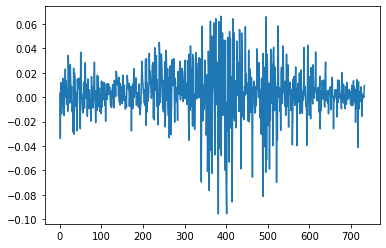

In [24]:
plt.plot(re_list)

In [26]:
qqq = [re_list[0]]
for i in range(1, len(re_list)):
    qqq.append(qqq[-1] + re_list[i])
    

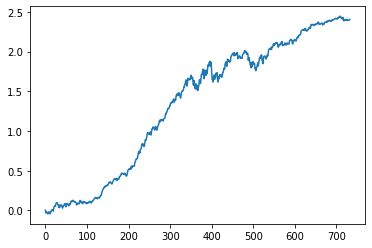

In [27]:
plt.plot(qqq)